In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


from tabulate import tabulate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pathlib
dataset_dir = "drive/MyDrive/Brain_tumor_detection/T1_brain"

In [4]:
batch_size = 16
img_height = 224
img_width = 224

SPLITTING INTO TRAIN AND TEST DS

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from numpy import testing


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(dataset_dir,
                                                 subset="training",
                                                 seed=1,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

val_set = train_datagen.flow_from_directory(dataset_dir,
                                                 subset="validation",
                                                 seed=1,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')




Found 2044 images belonging to 3 classes.
Found 510 images belonging to 3 classes.


CLASSES (SAME AS FOLDER NAMES)

In [6]:
class_names = ['Glioma', 'Meningioma', 'Pituitary']
print(class_names)

['Glioma', 'Meningioma', 'Pituitary']


PREFETCH DATASET 

IMPORT THE TRANSFER LEARNING MODEL

In [7]:
from keras.applications.resnet_v2 import ResNet50V2

In [8]:
res = ResNet50V2(input_shape=[224,224] + [3], weights='imagenet', include_top=False)# KEEPING THE TOP LAYER TRAINABLE


94683136/94668760 [==============================] - 1s 0us/step


In [9]:
for layer in res.layers:
    layer.trainable = False

In [10]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
x = Flatten()(res.output)


BUILDING THE MODEL

In [11]:
model = res.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=res.input, outputs = model)

In [12]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]
epochs=30
history = model.fit(
    training_set,
    validation_data = val_set,
    epochs=epochs,
    callbacks= callbacks
)

Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 1.0824 - accuracy: 0.5695
Epoch 1: val_accuracy improved from -inf to 0.68039, saving model to ./model.hdf5
64/64 [==============================] - 802s 12s/step - loss: 1.0824 - accuracy: 0.5695 - val_loss: 0.8848 - val_accuracy: 0.6804 - lr: 0.0010
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 0.9057 - accuracy: 0.6795
Epoch 2: val_accuracy improved from 0.68039 to 0.69412, saving model to ./model.hdf5
64/64 [==============================] - 352s 6s/step - loss: 0.9057 - accuracy: 0.6795 - val_loss: 0.8821 - val_accuracy: 0.6941 - lr: 0.0010
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 0.8579 - accuracy: 0.7319
Epoch 3: val_accuracy improved from 0.69412 to 0.70196, saving model to ./model.hdf5
64/64 [==============================] - 341s 5s/step - loss: 0.8579 - accuracy: 0.7319 - val_loss: 0.8681 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 4/30
64/64 [==================

EVALUATING THE MODEL

In [17]:
eval = model.evaluate(val_set)
eval

16/16 [==============================] - 67s 4s/step - loss: 0.8275 - accuracy: 0.7353


[0.8275381922721863, 0.7352941036224365]

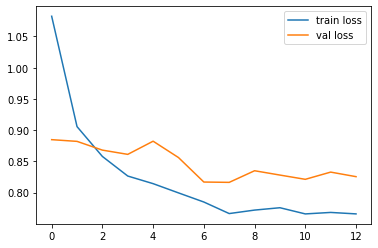

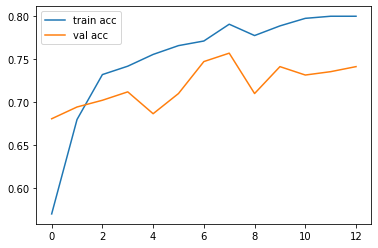

<Figure size 432x288 with 0 Axes>

In [16]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')